<a href="https://colab.research.google.com/github/ubsuny/PHY386/blob/Homework2025/2025/HW/dnxjay/HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Install Required Libraries

In [1]:
import tensorflow as tf
print("GPU available:", tf.config.list_physical_devices('GPU'))

GPU available: []


In [2]:
!pip install astropy scikit-learn tensorflow matplotlib numpy photutils auto-stretch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.5 MB/s eta 0:00:00


#2. Load and Stretch the RGB FITS Image

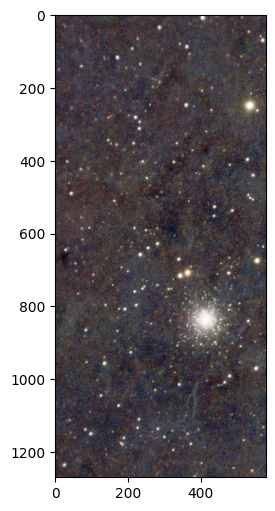

(1270, 580, 3)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from auto_stretch import apply_stretch
import requests
from io import BytesIO

# Raw file from github.
fits_url = "https://raw.githubusercontent.com/ubsuny/PHY386/main/data/6.fits"


response = requests.get(fits_url)
response.raise_for_status()


hdul = fits.open(BytesIO(response.content))

rgb_data = np.transpose(hdul[0].data, (1, 2, 0))
hdul.close()

top_margin = 100
bottom_margin = 550
left_margin = 150
right_margin = 350

cropped_rgb = rgb_data[top_margin:rgb_data.shape[0]-bottom_margin,
                       left_margin:rgb_data.shape[1]-right_margin, :]


# Display the image
plt.figure(figsize=(6, 6))
plt.imshow(apply_stretch(cropped_rgb))

plt.show()
cropped_rgb.shape

#3. Count Stars Using Astropy

In [14]:
def detect_stars(channel_data):
    """
    Detects stars in a 2D image using the DAOStarFinder algorithm.

    This function estimates the background statistics of the image using
    sigma-clipped statistics, then identifies star-like sources based on
    a Full Width at Half Maximum (FWHM) and a signal threshold.

    Parameters
    ----------
    channel_data : array_like
        A 2D NumPy array representing a single image channel (e.g., from a FITS image)
        where stars are to be detected. Pixel intensities should be linear (not log-scaled)
        and background-subtracted if possible.

    Returns
    -------
    astropy.table.Table
        A table of detected star sources, each with properties such as centroid
        positions, flux, sharpness, and roundness. Returns an empty table if no
        stars are found.

    Notes
    -----
    - Uses sigma-clipped statistics to robustly estimate the background mean,
      median, and standard deviation, excluding outliers like bright stars.
    - The DAOStarFinder algorithm identifies point sources based on their
      shape and brightness.
    - The detection threshold is set to 15 times the estimated background
      standard deviation, and the assumed FWHM of stars is 3 pixels.

    Examples
    --------
    >>> from astropy.io import fits
    >>> from astropy.stats import sigma_clipped_stats
    >>> from photutils.detection import DAOStarFinder
    >>> image_data = fits.getdata('example_image.fits')
    >>> stars = detect_stars(image_data)
    >>> print(len(stars))  # Number of stars detected
    """
    mean, median, std = sigma_clipped_stats(channel_data, sigma=3.0)
    finder = DAOStarFinder(fwhm=3.0, threshold=15.0*std)
    return finder(channel_data - median)

def equalize_channels(rgb_data):
  '''
  This function takes in the RGB channel data and counts the "stars" in each channel.
  It makes sure the number of stars are the same for each by finding which channel has the least stars and
  making the other channels only contain that same number of stars.
  The stars removed start with the least bright, leaving only the brightest stars.
  '''
  # Exctract RGB channels seperately
  r_channel = rgb_data[:, :, 0]
  g_channel = rgb_data[:, :, 1]
  b_channel = rgb_data[:, :, 2]

  # Count the stars in each channel
  r_sources = detect_stars(r_channel)
  g_sources = detect_stars(g_channel)
  b_sources = detect_stars(b_channel)

  # sort by brightness
  r_sources.sort('peak')
  g_sources.sort('peak')
  b_sources.sort('peak')

  # Find the number of stars in the least bright channel
  min_stars = min(len(r_sources), len(g_sources), len(b_sources))

  # Keep only the stars in the least bright channel
  r_sources = r_sources[:min_stars]
  g_sources = g_sources[:min_stars]
  b_sources = b_sources[:min_stars]

  return r_sources, g_sources, b_sources, min_stars


# calculate the mean of the RGB channels
avg_channel = np.mean(rgb_data[:, :, :], axis=2)

# Detect stars
mean_sources = detect_stars(avg_channel)
mean_sources.sort('peak')
r_sources, g_sources, b_sources, min_stars = equalize_channels(rgb_data)
mean_sources_brightest = mean_sources[:min_stars]

print(f"Number of detected stars: {len(mean_sources)}") # The number of stars calculated from the average of the channels
print(f"Number of detected stars within brightness of RGB stars: {len(mean_sources_brightest)}") # Number of stars from the average channel, with as many as were calculated from R, G and B
print(f"Number of detected red stars: {len(r_sources)}") # The number of stars should be the same for each channel.
print(f"Number of detected green stars: {len(g_sources)}")
print(f"Number of detected blue stars: {len(b_sources)}")


Number of detected stars: 420
Number of detected stars within brightness of RGB stars: 288
Number of detected red stars: 288
Number of detected green stars: 288
Number of detected blue stars: 288


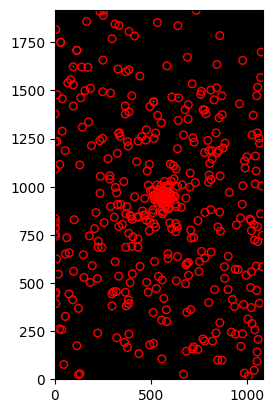

In [15]:
# Plot detected stars (average channel)
plt.imshow(avg_channel, cmap='gray', origin='lower')
plt.scatter(mean_sources['xcentroid'], mean_sources['ycentroid'], s=30, edgecolor='red', facecolors='none')
plt.show()

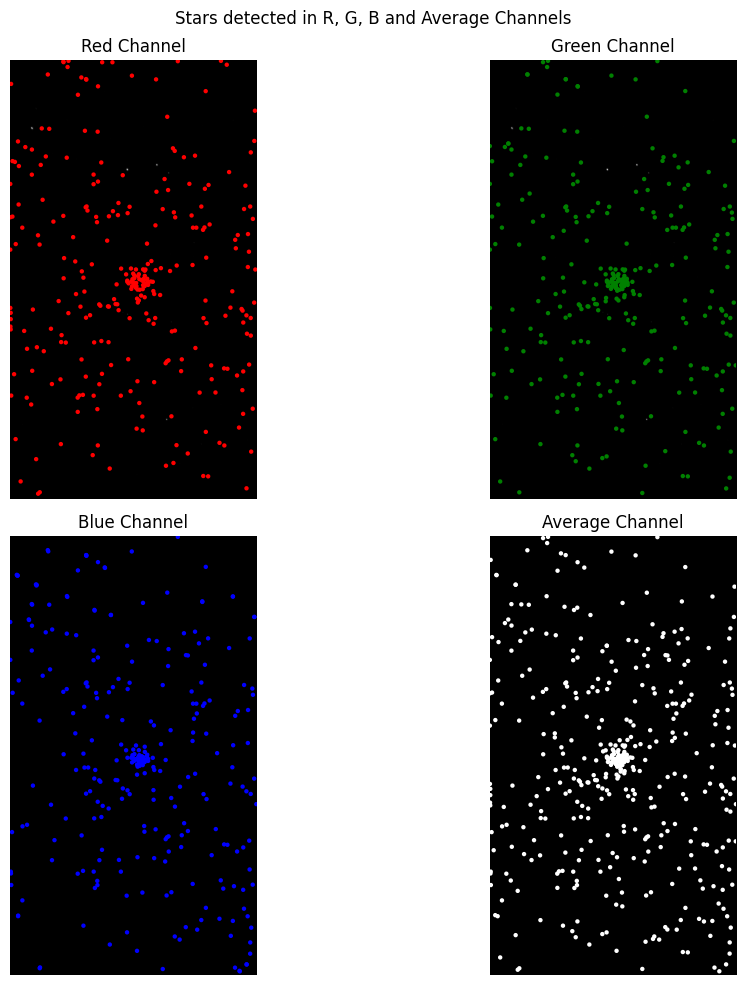

In [16]:
# 4-Sectioned plot:

# Extract the channel data
r_channel = rgb_data[:, :, 0]
g_channel = rgb_data[:, :, 1]
b_channel = rgb_data[:, :, 2]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Stars detected in R, G, B and Average Channels')
titles = ['Red Channel', 'Green Channel', 'Blue Channel', 'Average Channel']
channels = [r_channel, g_channel, b_channel, avg_channel]
sources = [r_sources, g_sources, b_sources, mean_sources]
colors = ['red', 'green', 'blue', 'white']

# Plot the stars for each channel
from photutils.aperture import CircularAperture # To draw circles around the stars
for ax, channel, sources, title, color in zip(axes.ravel(), channels, sources, titles, colors):
  ax.imshow(channel, cmap='gray', origin='lower')
  positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
  apertures = CircularAperture(positions, r=5.0)
  apertures.plot(ax, color=color, lw=1.5)
  ax.set_title(title)
  ax.axis('off')

plt.tight_layout()
plt.show()

In [17]:

# Extract features (brightness and size)
flux = mean_sources_brightest['flux']

# Compute size proxy
size = mean_sources_brightest['sharpness']

# Calculate color ratios of the sources

rg = r_sources['flux'] / g_sources['flux']
bg = b_sources['flux'] / g_sources['flux']

# Normalize features
flux_norm = (flux - np.min(flux)) / (np.max(flux) - np.min(flux))
size_norm = (size - np.min(size)) / (np.max(size) - np.min(size))
rg_norm = (rg - np.min(rg)) / (np.max(rg) - np.min(rg))
bg_norm = (bg - np.min(bg)) / (np.max(bg) - np.min(bg))

features = np.vstack([flux_norm, size_norm, rg_norm, bg_norm]).T

#Step 4: Autoencoder for Feature Compression

In [18]:
# Define an autoencoder model
input_layer = Input(shape=(4,)) # Updated to 4 features to make room for the r/g and b/g color ratios added in "Feature Extraction."
encoded = Dense(16, activation='relu')(input_layer) # Doubled the neurons to match the features in each layer.
encoded = Dense(4, activation='relu')(encoded)

decoded = Dense(16, activation='relu')(encoded)
decoded = Dense(4, activation='sigmoid')(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train autoencoder
autoencoder.fit(features, features, epochs=50, batch_size=16, verbose=1)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1231
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1061 
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0947 
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0904 
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0804 
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0735 
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0618 
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0523 
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0430 
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0346 
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0302 
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0237 
Epoch 13/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0215 
Epoch 14/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0203 
Epoch 15/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0239 
Epoch

#Step 5: Clustering with KMeans

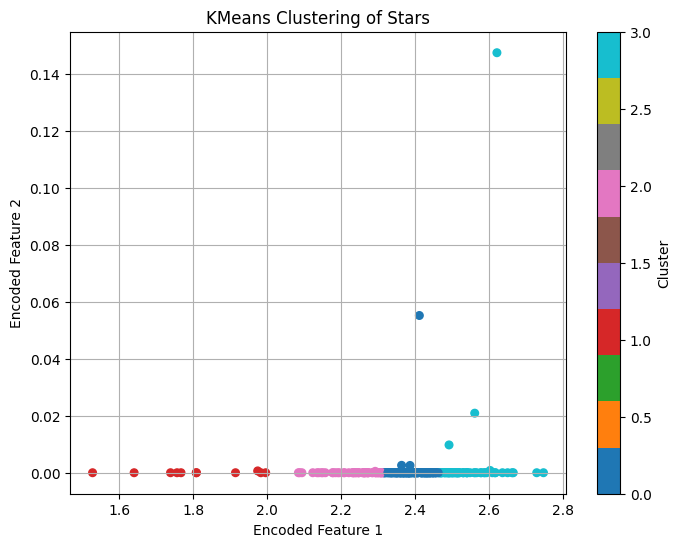

In [8]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def run_kmeans_clustering(features_2d, num_clusters=4, random_state=42):
    """
    Runs KMeans clustering on 2D compressed features.

    Parameters:
    - features_2d (np.ndarray): 2D array of compressed features from autoencoder.
    - num_clusters (int): Number of clusters to form (default 4).
    - random_state (int): Random seed for reproducibility.

    Returns:
    - predicted_labels (np.ndarray): Array of predicted cluster labels.
    - kmeans_model (KMeans): Trained KMeans model.
    """
    kmeans_model = KMeans(n_clusters=num_clusters, random_state=random_state)
    predicted_labels = kmeans_model.fit_predict(features_2d)
    return predicted_labels, kmeans_model


# --- Apply KMeans clustering to the encoded 2D features ---
predicted_labels, kmeans_model = run_kmeans_clustering(compressed_features, num_clusters=4)

# --- Visualize the clusters ---
def plot_clusters(encoded_features, labels):
    """
    Plots 2D encoded features with cluster labels as colors.

    Parameters:
    - encoded_features (np.ndarray): 2D features from autoencoder.
    - labels (np.ndarray): Cluster labels for each data point.
    """
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(encoded_features[:, 0], encoded_features[:, 1], c=labels, cmap='tab10', s=30)
    plt.colorbar(scatter, label='Cluster')
    plt.xlabel('Encoded Feature 1')
    plt.ylabel('Encoded Feature 2')
    plt.title('KMeans Clustering of Stars')
    plt.grid(True)
    plt.show()

# Plot the results
plot_clusters(compressed_features, predicted_labels)

#Step 6: Generating Synthetic Star Data and Visualize

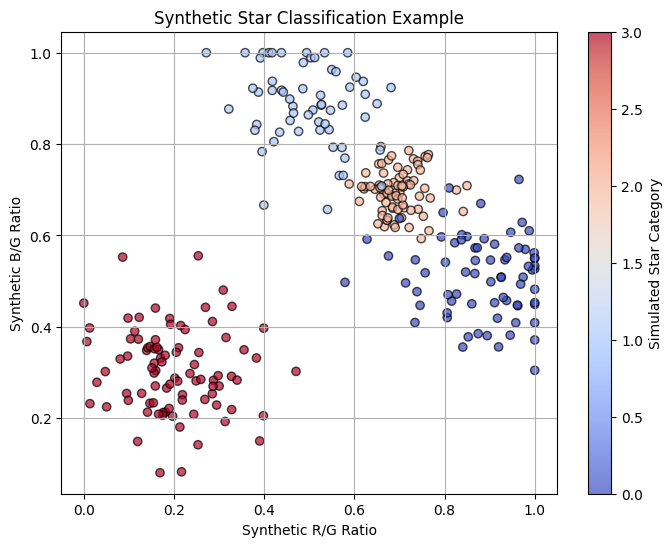

In [10]:
import numpy as np
import random
import matplotlib.pyplot as plt

def generate_synthetic_stars(num_stars=300):
    """
    Generates synthetic star data with predefined color and brightness properties
    to simulate different stellar populations.

    Parameters:
    - num_stars (int): Number of synthetic stars to generate.

    Returns:
    - stars (np.ndarray): Array of shape (num_stars, 2), where each row is [R/G ratio, B/G ratio].
    - labels (np.ndarray): Array of shape (num_stars,) containing the category of each star.
    """
    # Define categories: each has mean values for R/G, B/G and scatter (variance)
    categories = {
        0: {'rg': 0.9, 'bg': 0.5, 'scatter': 0.1},   # Red stars
        1: {'rg': 0.5, 'bg': 0.9, 'scatter': 0.1},   # Blue stars
        2: {'rg': 0.7, 'bg': 0.7, 'scatter': 0.05},  # White stars
        3: {'rg': 0.2, 'bg': 0.3, 'scatter': 0.1},   # Dim stars
    }

    stars = []
    labels = []

    for _ in range(num_stars):
        # Randomly choose a category
        category = random.choice(list(categories.keys()))
        base = categories[category]

        # Generate R/G and B/G values with some noise
        rg = max(0, min(1, np.random.normal(base['rg'], base['scatter'])))
        bg = max(0, min(1, np.random.normal(base['bg'], base['scatter'])))

        stars.append([rg, bg])
        labels.append(category)

    return np.array(stars), np.array(labels)


# --- Generate and plot synthetic stars ---
synthetic_stars, synthetic_labels = generate_synthetic_stars()

plt.figure(figsize=(8, 6))
plt.scatter(synthetic_stars[:, 0], synthetic_stars[:, 1],
            c=synthetic_labels, cmap='coolwarm', alpha=0.7, edgecolors='k')
plt.xlabel('Synthetic R/G Ratio')
plt.ylabel('Synthetic B/G Ratio')
plt.colorbar(label='Simulated Star Category')
plt.title('Synthetic Star Classification Example')
plt.grid(True)
plt.show()

#Step 7: Refining the Clustering

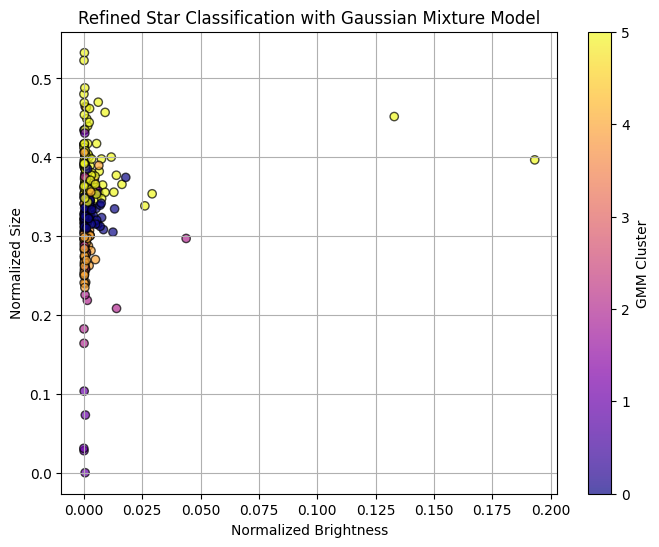

In [13]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# -------------------------
# Step 1: Apply GMM
# -------------------------

def apply_gmm_clustering(features_2d, num_clusters=6, random_state=42):
    """
    Applies Gaussian Mixture Model (GMM) clustering to compressed 2D features.

    Parameters:
    - features_2d (np.ndarray): The compressed features (e.g., from autoencoder).
    - num_clusters (int): Number of Gaussian components (clusters) to use.
    - random_state (int): Seed for reproducibility.

    Returns:
    - predicted_labels (np.ndarray): Cluster assignments for each data point.
    - gmm_model (GaussianMixture): Trained GMM model.
    """
    gmm_model = GaussianMixture(n_components=num_clusters, random_state=random_state)
    predicted_labels = gmm_model.fit_predict(features_2d)
    return predicted_labels, gmm_model

# Apply GMM clustering on compressed features from filtered data
num_clusters_gmm = 6
predicted_labels_gmm, gmm = apply_gmm_clustering(compressed_features, num_clusters=num_clusters_gmm)

# -------------------------
# Step 2: Align Visualization Data
# -------------------------

# These must match filtered_features shape (same as compressed_features)
flux_norm = flux_norm[filtered_indices]
size_norm = size_norm[filtered_indices]

# -------------------------
# Step 3: Visualize GMM Results
# -------------------------

plt.figure(figsize=(8, 6))
plt.scatter(flux_norm, size_norm, c=predicted_labels_gmm, cmap='plasma', alpha=0.7, edgecolors='k')
plt.xlabel('Normalized Brightness')
plt.ylabel('Normalized Size')
plt.colorbar(label='GMM Cluster')
plt.title('Refined Star Classification with Gaussian Mixture Model')
plt.grid(True)
plt.show()